# Project Overview

## Objective

Develop an advanced sentiment analysis model to classify and analyze sentiments expressed in financial tweets. This model will leverage state-of-the-art NLP techniques to provide actionable insights into market sentiments.

![Alt text](images/logo.png)

Key Points
- Dataset: The dataset consists of tweets related to financial news, each labeled with a sentiment class (bullish, bearish, neutral).
- Goal: Utilize the labeled tweets to fine-tune a pre-trained language model capable of accurate sentiment analysis.Extract and visualize sentiment trends in financial tweets to provide insights for financial analysts
- Methodology:
  - Load and preprocess the dataset, including cleaning and handling imbalanced datasets.
  - Apply parameter-efficient fine-tuning using the Hugging Face peft library
  - Evaluate and compare the performance of the fine-tuned model against the baseline

By structuring the project with this approach, we ensure clarity and focus on the main objective, while systematically detailing the supporting information and methodology.

### Imports

In [2]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re

from datasets import Dataset
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType

from sklearn.metrics import classification_report

print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())

C:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is CUDA available:  True
CUDA device count:  1


### Processing and model related functions

In [3]:
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing special characters,
    but keeping numbers and stop words.

    Args:
    text (str): The input text to preprocess.

    Returns:
    str: The preprocessed text.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters but keep numbers
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    return text
    
def preprocess_function(examples):
    examples['text'] = [preprocess_text(text) for text in examples['text']]
    return examples

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    report = classification_report(labels, predictions, target_names=['Bearish', 'Bullish', 'Neutral'], output_dict=True, zero_division=0)
    
    accuracy = (predictions == labels).mean()
    
    # Extract precision, recall, and F1 score for each class
    precision_neg = report['Bearish']['precision']
    recall_neg = report['Bearish']['recall']
    f1_neg = report['Bearish']['f1-score']
    
    precision_pos = report['Bullish']['precision']
    recall_pos = report['Bullish']['recall']
    f1_pos = report['Bullish']['f1-score']
    
    precision_neu = report['Neutral']['precision']
    recall_neu = report['Neutral']['recall']
    f1_neu = report['Neutral']['f1-score']
    
    return {
        "accuracy": accuracy,
        "precision_negative": precision_neg,
        "recall_negative": recall_neg,
        "f1_negative": f1_neg,
        "precision_positive": precision_pos,
        "recall_positive": recall_pos,
        "f1_positive": f1_pos,
        "precision_neutral": precision_neu,
        "recall_neutral": recall_neu,
        "f1_neutral": f1_neu,
    }

def create_results_dataframe(results, model_name):
    results_df = pd.DataFrame([{
        "Model": model_name,
        "Loss": results.get('eval_loss', None),
        "Accuracy": results.get('eval_accuracy', None),
        "Precision (Negative)": results.get('eval_precision_negative', None),
        "Recall (Negative)": results.get('eval_recall_negative', None),
        "F1 Score (Negative)": results.get('eval_f1_negative', None),
        "Precision (Neutral)": results.get('eval_precision_neutral', None),
        "Recall (Neutral)": results.get('eval_recall_neutral', None),
        "F1 Score (Neutral)": results.get('eval_f1_neutral', None),
        "Precision (Positive)": results.get('eval_precision_positive', None),
        "Recall (Positive)": results.get('eval_recall_positive', None),
        "F1 Score (Positive)": results.get('eval_f1_positive', None),
        "Train Runtime": results.get('eval_runtime', None)
    }])
    return results_df

def infer(model, tokenizer, text):
    # Preprocess the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class
    predictions = torch.argmax(outputs.logits, dim=-1)
    
    return predictions.item()

### Formating and Plotting functions

In [4]:
def thousands_formatter(x, pos):
    return f'{int(x):,}'

def percentage_formatter(x, pos):
    return f'{x:.1%}'

def plot_label_distribution(df, label_column='label'):
    
    # Create the figure
    plt.figure(figsize=(10, 3))
    
    # Count the occurrences of each label
    label_counts = df[label_column].value_counts()
    
    # Define the label mapping
    label_mapping = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
    
    # Map the labels
    mapped_labels = label_counts.index.map(label_mapping)
    
    # Calculate percentages
    total = label_counts.sum()
    percentages = (label_counts / total * 100).round(1)
    
    # Plot the data as horizontal bars
    bars = plt.barh(mapped_labels, label_counts.values, color='#a4b7d7', edgecolor='white')
    
    # Add the text with percentages at the end of each bar
    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f'{percentage}%', va='center')
    
    # Customize the plot
    plt.title('Labels Counts')
    plt.xlabel('Count')
    plt.ylabel('Label')
    
    # Remove ticks
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    
    # Hide spines
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    # Apply thousands formatter to x-axis
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Show the plot
    plt.show()

def plot_model_metrics(df):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

    # Function to get the color for each model
    def get_color(model_name):
        return special_color if model_name == 'PEFT Model V1' else default_color

    # Function to add annotations
    def add_annotations(ax, values):
        for i, value in enumerate(values):
            ax.text(value, i, f'{value:.2f}', va='center', ha='left')

    # Define colors
    default_color = '#a4b7d7'
    special_color = '#0A2647'
    precision_colors = ['#405D72', '#758694', '#F7E7DC']
    recall_colors = ['#405D72', '#758694', '#F7E7DC']
    f1_colors = ['#405D72', '#758694', '#F7E7DC']
    
    colors = [get_color(model) for model in df['Model']]
    
    # Loss
    axes[0, 0].barh(df['Model'], df['Loss'], color=colors, edgecolor='white')
    axes[0, 0].set_title('Loss')
    add_annotations(axes[0, 0], df['Loss'])

    # Overall Accuracy
    axes[0, 1].barh(df['Model'], df['Accuracy'], color=colors, edgecolor='white')
    axes[0, 1].set_title('Overall Accuracy')
    add_annotations(axes[0, 1], df['Accuracy'])
    
    # Evaluation Runtime
    axes[0, 2].barh(df['Model'], df['Train Runtime'], color=colors, edgecolor='white')
    axes[0, 2].set_title('Evaluation Runtime')
    add_annotations(axes[0, 2], df['Train Runtime'])
    
    # Precision
    precision_data = df[['Model', 'Precision (Negative)', 'Precision (Neutral)', 'Precision (Positive)']]
    precision_data.set_index('Model').plot(kind='barh', ax=axes[1, 0], color=precision_colors, edgecolor='white')
    axes[1, 0].set_title('Precision')

    # Recall
    recall_data = df[['Model', 'Recall (Negative)', 'Recall (Neutral)', 'Recall (Positive)']]
    recall_data.set_index('Model').plot(kind='barh', ax=axes[1, 1], color=recall_colors, edgecolor='white')
    axes[1, 1].set_title('Recall')

    # F1 Score
    f1_data = df[['Model', 'F1 Score (Negative)', 'F1 Score (Neutral)', 'F1 Score (Positive)']]
    f1_data.set_index('Model').plot(kind='barh', ax=axes[1, 2], color=f1_colors, edgecolor='white')
    axes[1, 2].set_title('F1 Score')

    # Hide spines for all subplots
    for ax in axes.flat:
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()

## Data preparation, exploration and analysis

Preprocessing text helps in making the data more uniform and easier for the model to process, which ultimately leads to better performance in tasks like sentiment analysis. 

By reducing noise and ensuring consistency, preprocessing allows the model to learn more effectively from the data.
Preprocessing text is a crucial step in preparing data for natural language processing (NLP) tasks, including sentiment analysis.

  - Conssitency: Converting text to lowercase ensures that words are treated uniformly
  - Noise Reduction: Removing special characters, numbers, and punctuation helps to eliminate noise that can confuse the model. Special characters and punctuation often do not contribute to the sentiment or meaning of the text and can be safely removed
  - More effective tokenization:  By ensuring the text is clean and consistent, the tokenizer can generate more meaningful tokens.
  - Improved Model Performance: Clean and consistent text helps the model learn better patterns. Preprocessing steps reduce the variability in the text data, making it easier for the model to focus on the important parts of the text, such as sentiment-laden words.

_The current model we are using does not distinguish between uppercase and lowercase letters, which may affect its ability to capture the nuances in sentiment expressed through capitalization. In future iterations, we could address this limitation by utilizing a model like BERT, which can preserve and interpret the differences between capitalized and lowercase text, potentially enhancing the accuracy of sentiment analysis._

The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their sentiment.

The dataset holds 11,932 documents annotated with 3 labels:

- Label 0: "Bearish" 
- Label 1: "Bullish" 
- Label 2: "Neutral"

https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment?row=18


In [5]:
# Load the financial tweets dataset
dataset = load_dataset('zeroshot/twitter-financial-news-sentiment')
dataset = dataset.map(preprocess_function, batched=True)

train_df= dataset['train'].to_pandas()
train_df.head()

,text,label
0,bynd jpmorgan reels in expectations on beyond...,0
1,ccl rcl nomura points to bookings weakness at...,0
2,cx cemex cut at credit suisse jp morgan on we...,0
3,ess btig research cuts to neutral httpstcomcyf...,0
4,fnko funko slides after piper jaffray pt cut ...,0


As observed, the dataset consists of two columns: text and label. When we plot the distribution of each label, it is evident that the training set is imbalanced, with bullish tweets making up 65% of the total tweets. Ideally, to train the model effectively, it would be beneficial to have a more balanced dataset with similar numbers of bearish, neutral, and bullish tweets.
    

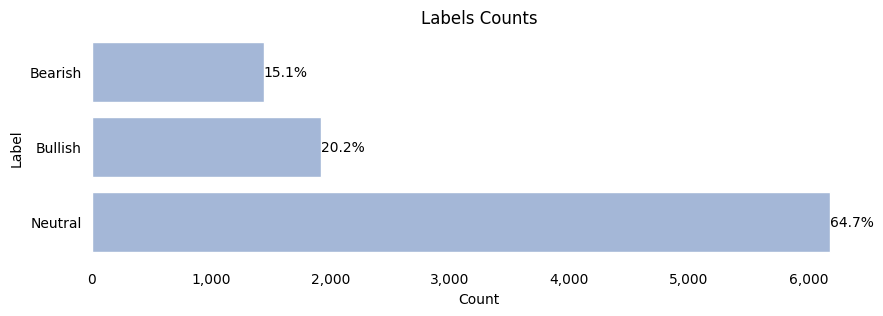

In [6]:
plot_label_distribution(train_df)

Rebalancing the training sample in traditional machine learning models is a common practice because these models often struggle with class imbalance. When there is an imbalance, the model may become biased towards the majority class, leading to poor performance on the minority class. However, the combination of large-scale pre-training, contextual learning, token-level predictions, and advanced regularization techniques makes LLMs more robust to class imbalance compared to traditional machine learning models. This robustness reduces the need for explicit rebalancing of the training sample.

## Selecting the "right" model

- Why NOT bert-base-cased: Although BERT-Base-Cased provides superior language understanding and captures nuances effectively, it is computationally intensive. This makes it less suitable for scenarios where computational resources are limited or when a faster model is needed
- Why distilbert-base-uncased: DistilBERT-Base-Cased offers a streamlined, faster version of BERT while retaining 97% of its language understanding capabilities. This efficiency makes it suitable for projects with computational resource constraints or the need for faster processing times.

In [7]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')

In [8]:
# Apply the tokenization function to the preprocessed dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2388
    })
})

In [9]:
tokenized_df = pd.DataFrame(tokenized_datasets['train'])

In [10]:
tokenized_df

,text,label,input_ids,attention_mask
0,bynd jpmorgan reels in expectations on beyond...,0,"[101, 1118, 3276, 179, 9952, 1766, 3820, 24548...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,ccl rcl nomura points to bookings weakness at...,0,"[101, 14402, 1233, 187, 1665, 1233, 1185, 1453...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,cx cemex cut at credit suisse jp morgan on we...,0,"[101, 172, 1775, 172, 5521, 11708, 2195, 1120,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,ess btig research cuts to neutral httpstcomcyf...,0,"[101, 13936, 1116, 171, 3121, 1403, 1844, 7484...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,fnko funko slides after piper jaffray pt cut ...,0,"[101, 175, 17075, 19657, 1186, 15766, 1170, 94...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
9538,the weeks gainers and losers on the stoxx euro...,2,"[101, 1103, 2277, 4361, 1468, 1105, 19398, 111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9539,tupperware brands among consumer gainers unile...,2,"[101, 189, 4455, 3365, 7109, 10915, 1621, 8440...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9540,vtv therapeutics leads healthcare gainers myom...,2,"[101, 191, 1204, 1964, 20340, 1116, 4501, 1252...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9541,work xpo pyx and amkr among after hour movers,2,"[101, 1250, 193, 5674, 185, 19367, 1105, 1821,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Evaluating the base model

In [16]:

# Load the tokenizer and model
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=3, 
    id2label={0:"Bearish", 1:"Bullish", 2:"Neutral"}, 
    label2id={"Bearish":0, "Bullish":1, "Neutral":2}
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./data/model', # where we save the model checkpoiints
    num_train_epochs=0,  # No training, only evaluation
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

# Evaluate the base model
base_model_metrics = trainer.evaluate()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
results_df_base = create_results_dataframe(base_model_metrics,"Base Model Metrics")
results_df_base

,Model,Loss,Accuracy,Precision (Negative),Recall (Negative),F1 Score (Negative),Precision (Neutral),Recall (Neutral),F1 Score (Neutral),Precision (Positive),Recall (Positive),F1 Score (Positive),Train Runtime
0,Base Model Metrics,1.053732,0.655779,0.0,0.0,0.0,0.655779,1.0,0.792109,0.0,0.0,0.0,25.0604


The metrics shown in the table provide an evaluation of the base model's performance on the classification task of financial tweets with three classes: Negative, Neutral, and Positive. 

The model correctly classified approximately 65.58% of the instances. (Not very high)
Train Runtime: 25.0604, representing the time taken for the evaluation process.


## Training the models
### Fine-tuning the base model

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=3, id2label={0:"Bearish",1:"Bullish",2:"Neutral"}, label2id={"Bearish":0,"Bullish":1,"Neutral":2})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./data/model', # where we save the model checkpoiints
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
)


In [12]:
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
        
)

In [13]:
# Fine-tune the model
trainer.train()
trainer.save_model("./data/model")

Step,Training Loss
500,0.672000
1000,0.382400
1500,0.207000


### Parameter Efficient Fine-Tuning (PEFT) 


In [14]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained("./data/model")

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=1,
    lora_alpha=1,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    bias="none"
)

peft_model = get_peft_model(pretrained_model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 629,763 || all params: 66,413,574 || trainable%: 0.9482


In [15]:
peft_training_args = TrainingArguments(
    output_dir="./data/peft_training",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],  # Use 'test' split as validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

peft_trainer.train()
peft_trainer.save_model("./data/peft_model_v1")

Step,Training Loss
500,0.073600
1000,0.070400
1500,0.051300


In [16]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained("./data/model")

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=1,
    lora_alpha=1,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    bias="none"
)

peft_model = get_peft_model(pretrained_model, peft_config)
peft_model.print_trainable_parameters()

peft_training_args = TrainingArguments(
    output_dir="./data/peft_training_v2",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.05
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],  # Use 'test' split as validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

peft_trainer.train()
peft_trainer.save_model("./data/peft_model_v2")

trainable params: 629,763 || all params: 66,413,574 || trainable%: 0.9482


Step,Training Loss
500,0.086200
1000,0.065700
1500,0.072500
2000,0.083500
2500,0.070500
3000,0.042100
3500,0.090500



## Evaluating both models (Fine-tuned model vs PEFT Model v1 vs PEFT Model v2)

To evaluate both models, we need to load them and obtain key performance metrics, such as the loss function and accuracy.


### Fine-Tuned Model Evaluation

In [18]:
# Path to the directory where the model checkpoint is saved
model_path = './data/model'

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the training arguments
training_args = TrainingArguments(
    output_dir='./data/model',
    per_device_eval_batch_size=16,
    logging_dir='./logs/model',
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets['validation'],  # Assuming you have a validation dataset
    compute_metrics=compute_metrics,
)

# Evaluate the model
results = trainer.evaluate()

In [19]:
results_df_finetuned = create_results_dataframe(results,"Fine-Tuned Model")
results_df_finetuned

,Model,Loss,Accuracy,Precision (Negative),Recall (Negative),F1 Score (Negative),Precision (Neutral),Recall (Neutral),F1 Score (Neutral),Precision (Positive),Recall (Positive),F1 Score (Positive),Train Runtime
0,Fine-Tuned Model,0.525072,0.871441,0.765363,0.789625,0.777305,0.912794,0.915709,0.914249,0.812636,0.785263,0.798715,22.6798


### Peft v1 Evaluation

In [20]:
model_path = "./data/peft_model_v1"
peft_model = AutoModelForSequenceClassification.from_pretrained(model_path)

peft_training_args = TrainingArguments(
    output_dir="./data/peft_training",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs/model/peft_model_v1',
    logging_steps=10,
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],  # Use 'test' split as validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate the model
results = peft_trainer.evaluate()

In [21]:
results_df_peft_v1 = create_results_dataframe(results,"PEFT Model V1")
results_df_peft_v1

,Model,Loss,Accuracy,Precision (Negative),Recall (Negative),F1 Score (Negative),Precision (Neutral),Recall (Neutral),F1 Score (Neutral),Precision (Positive),Recall (Positive),F1 Score (Positive),Train Runtime
0,PEFT Model V1,0.541809,0.873534,0.770308,0.792507,0.78125,0.914122,0.917625,0.91587,0.814815,0.787368,0.800857,24.4521


### Peft v2 Evaluation

In [22]:
model_path = "./data/peft_model_v2"
peft_model = AutoModelForSequenceClassification.from_pretrained(model_path)

peft_training_args = TrainingArguments(
    output_dir="./data/peft_training_v2",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.05,
    logging_dir='./logs/model/peft_model_v1',
    logging_steps=10,
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],  # Use 'test' split as validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate the model
results = peft_trainer.evaluate()

In [23]:
results_df_peft_v2 = create_results_dataframe(results,"PEFT Model V2")
results_df_peft_v2

,Model,Loss,Accuracy,Precision (Negative),Recall (Negative),F1 Score (Negative),Precision (Neutral),Recall (Neutral),F1 Score (Neutral),Precision (Positive),Recall (Positive),F1 Score (Positive),Train Runtime
0,PEFT Model V2,0.608422,0.872697,0.768156,0.792507,0.780142,0.914013,0.916347,0.915179,0.813043,0.787368,0.8,24.7862


## Analysis and Model evaluation

In [24]:
result_df = pd.concat([results_df_finetuned, results_df_peft_v1, results_df_peft_v2])

In [30]:
result_df

,Model,Loss,Accuracy,Precision (Negative),Recall (Negative),F1 Score (Negative),Precision (Neutral),Recall (Neutral),F1 Score (Neutral),Precision (Positive),Recall (Positive),F1 Score (Positive),Train Runtime
0,Fine-Tuned Model,0.525072,0.871441,0.765363,0.789625,0.777305,0.912794,0.915709,0.914249,0.812636,0.785263,0.798715,22.6798
0,PEFT Model V1,0.541809,0.873534,0.770308,0.792507,0.781250,0.914122,0.917625,0.915870,0.814815,0.787368,0.800857,24.4521
0,PEFT Model V2,0.608422,0.872697,0.768156,0.792507,0.780142,0.914013,0.916347,0.915179,0.813043,0.787368,0.800000,24.7862


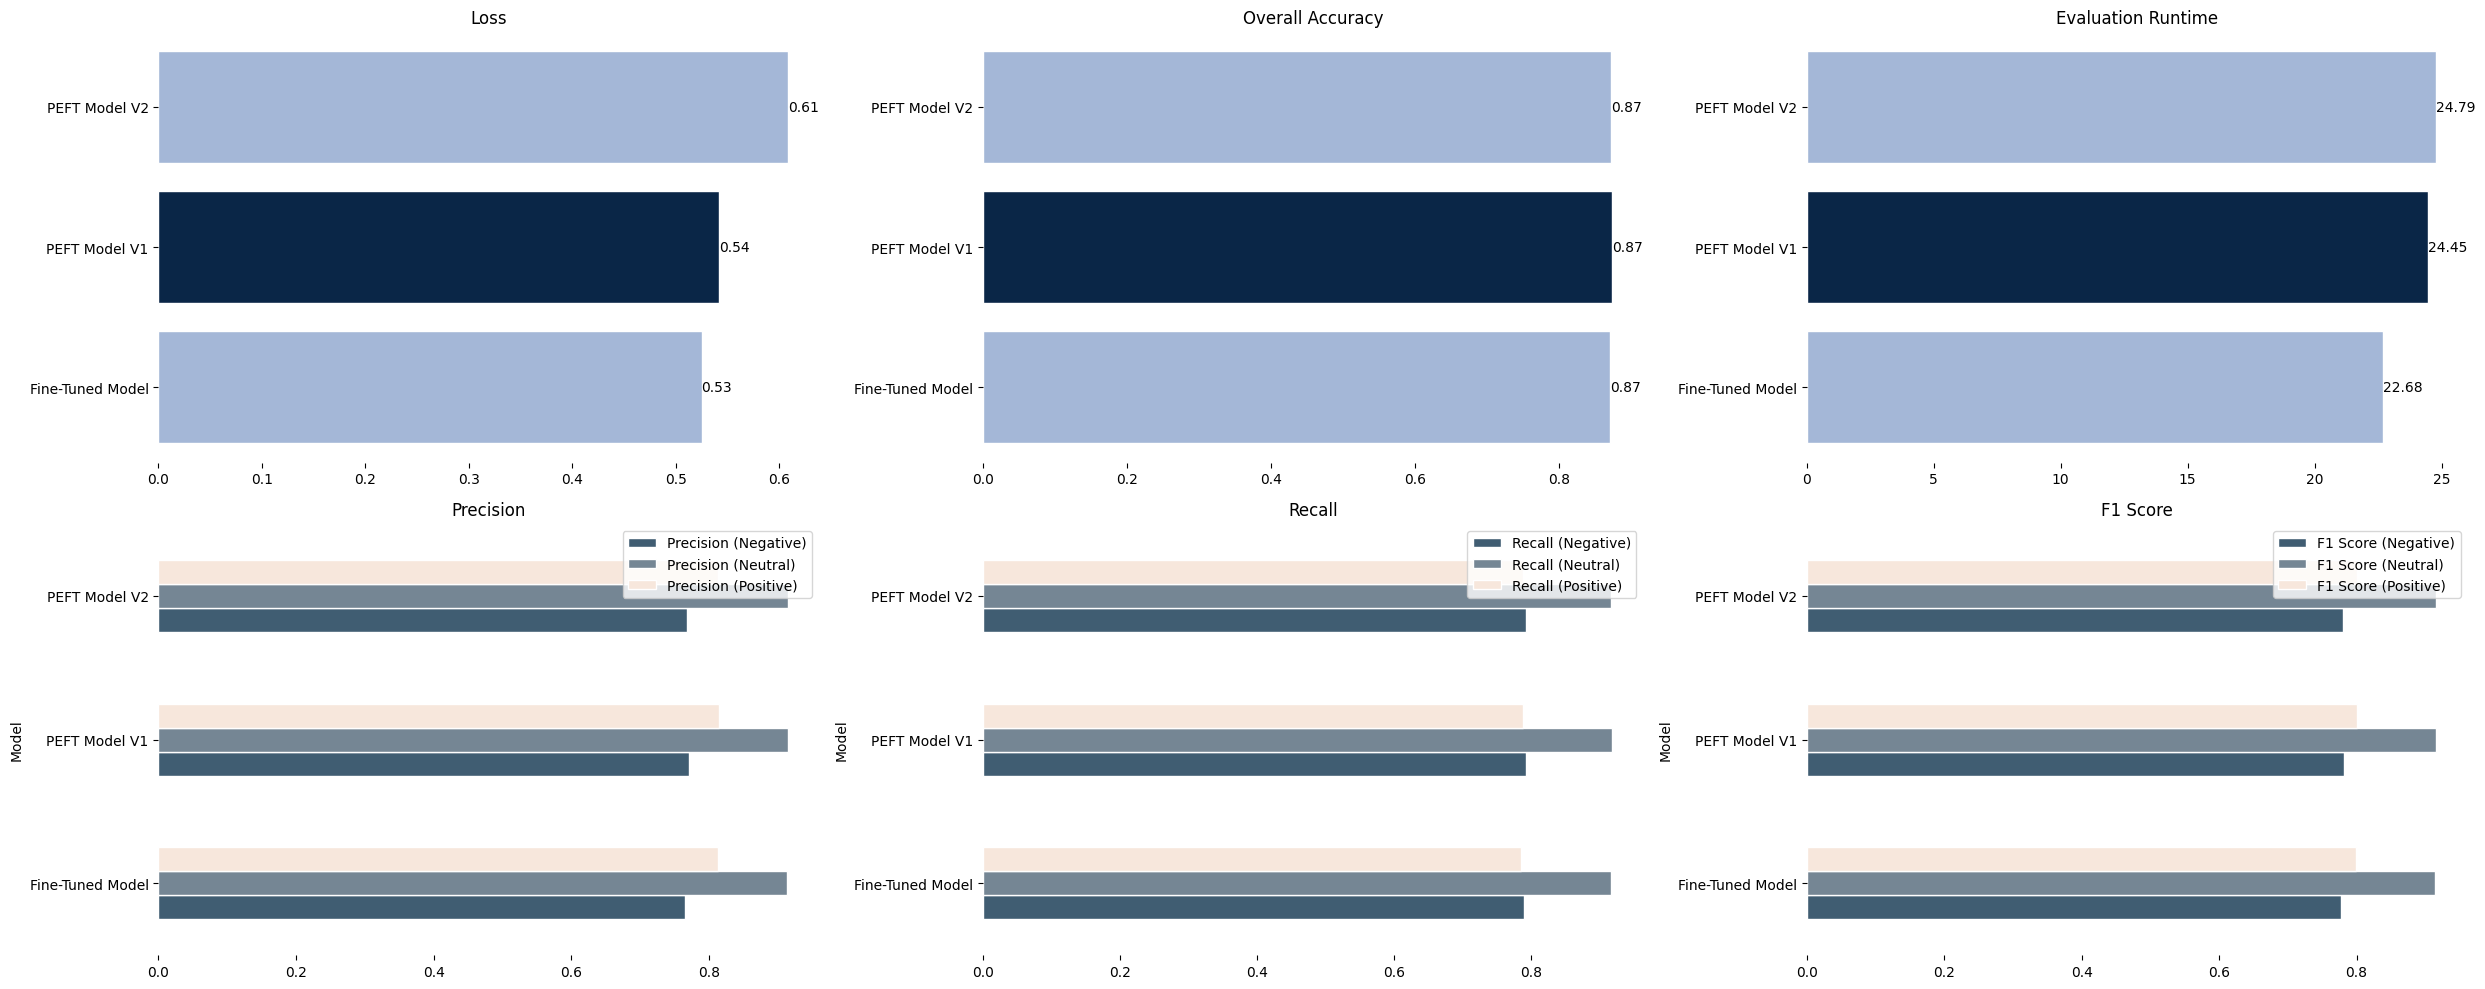

In [41]:
plot_model_metrics(result_df)

Conclusion:
- Considering all metrics, PEFT Model V1 stands out as the best model. It has the highest accuracy, best overall precision, recall, and F1 scores across all categories (Negative, Neutral, Positive). Although it has a slightly higher loss than the Fine-Tuned Model and longer training time, the improvement in other critical performance metrics justifies its selection as the best model.

Therefore, PEFT Model V1 is considered the best model based on the provided metrics.

## Inference


In [42]:
fine_tuned_model_path='./data/model'
peft_v1_model_path='./data/peft_model_v1'
peft_v2_model_path='./data/peft_model_v2'

base_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=3)
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(fine_tuned_model_path, num_labels=3)
peft_v1_model = AutoModelForSequenceClassification.from_pretrained(peft_v1_model_path, num_labels=3)
peft_v2_model= AutoModelForSequenceClassification.from_pretrained(peft_v2_model_path, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
sample_text = "nomura points to bookings weakness at carnival and royal caribbean"

In [44]:
original_prediction = infer(base_model, tokenizer, sample_text)
fine_tuned_prediction = infer(fine_tuned_model, tokenizer, sample_text)
peftv1_prediction = infer(peft_v1_model, tokenizer, sample_text)
peftv2_prediction = infer(peft_v2_model, tokenizer, sample_text)

In [45]:
print(f"Prediction from original model: {original_prediction}")
print(f"Prediction from fine-tuned model: {fine_tuned_prediction}")
print(f"Prediction from peft_v1 model: {peftv1_prediction}")
print(f"Prediction from peft_v2 model: {peftv2_prediction}")

Prediction from original model: 2
Prediction from fine-tuned model: 0
Prediction from peft_v1 model: 0
Prediction from peft_v2 model: 0


In [54]:
train_df['text']

0       bynd  jpmorgan reels in expectations on beyond...
1       ccl rcl  nomura points to bookings weakness at...
2       cx  cemex cut at credit suisse jp morgan on we...
3       ess btig research cuts to neutral httpstcomcyf...
4       fnko  funko slides after piper jaffray pt cut ...
                              ...                        
9538    the weeks gainers and losers on the stoxx euro...
9539    tupperware brands among consumer gainers unile...
9540    vtv therapeutics leads healthcare gainers myom...
9541        work xpo pyx and amkr among after hour movers
9542                 yndx i qd and oesx among tech movers
Name: text, Length: 9543, dtype: object

The results from the predictions indicate that all the models except the original one successfully captured the correct label. Specifically, the fine-tuned model, PEFT Model V1, and PEFT Model V2 all predicted the label as 0, demonstrating their accuracy and effectiveness in identifying the correct classification. In contrast, the original model predicted the label as 2, which is incorrect. This discrepancy highlights the significant improvements and enhanced performance achieved through fine-tuning and applying parameter-efficient fine-tuning (PEFT) techniques. These refined models have evidently managed to better understand the underlying patterns and nuances of the data, thereby providing more accurate predictions compared to the original, unrefined model.






